In [1]:
import os
import json
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt
from dataset import CarotidDataset
from unet import UNet
from utils import DiceLoss
from torchvision import transforms

from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt

In [2]:
#MODEL = 'unet_1a'
#MODEL = 'unet_2'
MODEL = 'unet_3'

In [3]:
batch_size = 1
data = CarotidDataset(crop=False)
generator = torch.Generator().manual_seed(42)
_, _, test_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator=generator)
dataloader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=1)
net = UNet(in_channels=3, n_classes=1, depth=5, batch_norm=True, padding=True, up_mode='upsample')
net.load_state_dict(torch.load(f'models/{MODEL}.pth'))
net.eval()
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=1)

In [4]:
inputs, labels = next(iter(dataloader))

In [5]:
inputs.shape

torch.Size([1, 3, 512, 512])

In [6]:
preds = net(inputs)
preds.shape

torch.Size([1, 1, 512, 512])

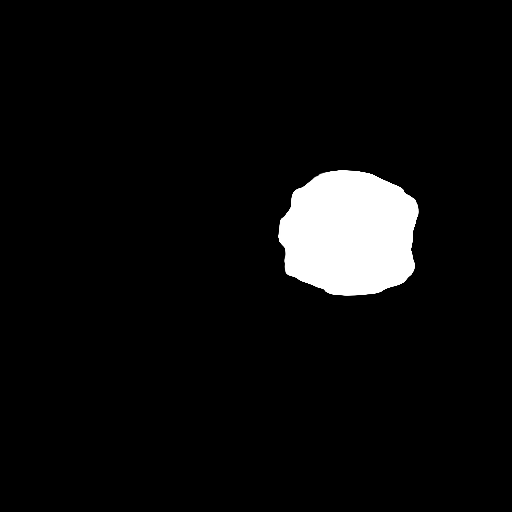

In [7]:
transforms.functional.to_pil_image(preds[0])

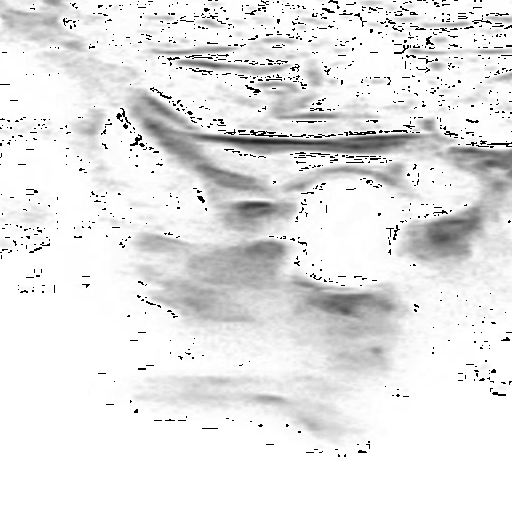

In [8]:
transforms.functional.to_pil_image(inputs[0][2])

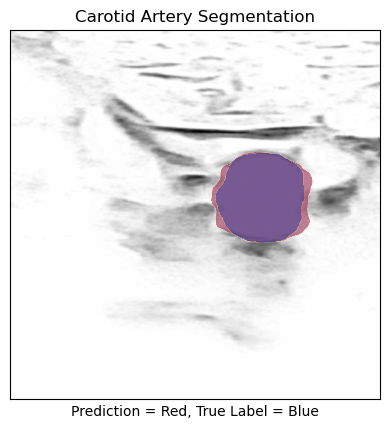

In [9]:
def plot_pred(preds, inputs, labels=None):
    pred_out = preds[0][0].detach().numpy()
    background = inputs[0][2].detach().numpy()
    plt.imshow(background, cmap='Greys', alpha=1)
    plt.imshow(pred_out, 
            cmap='YlOrRd',
            alpha=pred_out*.5)
    if labels != None:
        labels = labels > 0
        labels = labels.type(torch.int8)
        label_out = labels[0][0].numpy()
        plt.imshow(label_out, 
           cmap='RdYlBu', 
           alpha=label_out*.5)
        plt.xlabel('Prediction = Red, True Label = Blue',)
    else:
        plt.xlabel('Prediction = Red',)
    plt.title('Carotid Artery Segmentation')
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    
    plt.show()

plot_pred(preds, inputs, labels)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

28954567

In [11]:
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.nn import functional as F

In [12]:
data.image_paths[-1]

'data/Common Carotid Artery Ultrasound Images/US images/202201121819140033VAS_slice_1488.png'

In [13]:
image = read_image(data.image_paths[-1])
image = image.float()

In [14]:
image.shape

torch.Size([3, 749, 709])

In [15]:
h_segs = [x for x in range(round(image.shape[1]/256))]
v_segs = [y for y in range(round(image.shape[2]/256))]

In [16]:
h_segs

[0, 1, 2]

In [17]:
v_segs

[0, 1, 2]

In [18]:
h_start = 0
v_start = 0
h_end = h_start + 256
v_end = v_start + 256

In [19]:
inputs.shape

torch.Size([1, 3, 512, 512])

In [20]:
image_out = torch.zeros(1, image.shape[1], image.shape[2])

In [21]:
img_out.shape

NameError: name 'img_out' is not defined

In [ ]:
img_out = torch.zeros(1,1, image.shape[1], image.shape[2])
for x in h_segs:
    for y in v_segs:
        img_ = image[:,h_start:h_end,v_start:v_end]
        #if x == max(h_segs):
        h_pad = 256 - img_.shape[1]
        v_pad = 256 - img_.shape[2]
        img_ = F.pad(img_, [0,v_pad,0,h_pad], value=0).unsqueeze(0)
        pred_ = net(img_)
        print(img_.shape)
        print(pred_.shape)
        print("")
        img_out[0,h_start:h_end,v_start:v_end] = pred_
        v_start = v_end
        v_end +=256
    h_start = h_end
    h_end +=256


In [ ]:
img_.unsqueeze(0).shape

In [ ]:
h_pad = 256 - img_.shape[1]
v_pad = 256 - img_.shape[2]

In [ ]:
h_pad + img_.shape[1]

In [ ]:
v_pad

In [ ]:
F.pad(img_, [0,v_pad,0,h_pad], value=0).shape